In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.preprocessing.image import img_to_array, load_img

train_folder = "data/train"
test_folder = "data/test"

# Original Dimensions
sense_score_cols = ["sourness", "bitterness"]
image_size = (299, 299)
channels = 3

In [2]:
def load_sense_dataset(data_folder, sense_score_cols, image_size, channels):
    df_sense = pd.read_csv(f"{data_folder}/sense_score.csv")
    image_arrays = np.ndarray(
        shape=(len(df_sense), image_size[0], image_size[1], channels),
        dtype=np.float32
    )
    sense_scores = df_sense[sense_score_cols].values
    for i, rows in df_sense.iterrows():
        category = rows["category"]
        filename = rows["filename"]
        img = load_img(f"{data_folder}/{category}/{filename}", color_mode='rgb', target_size=image_size)
        image_arrays[i] = img_to_array(img)
        
    return image_arrays, sense_scores


def compare_TV(history):
    import matplotlib.pyplot as plt

    # Setting Parameters
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(mae))

    # 1) maeracy Plt
    plt.plot(epochs, mae, 'bo' ,label = 'training mae')
    plt.plot(epochs, val_mae, 'b' , label= 'validation mae')
    plt.title('Training and Validation mae')
    plt.legend()

    plt.figure()

    # 2) Loss Plt
    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

In [3]:
X_train, y_train = load_sense_dataset(train_folder, sense_score_cols, image_size, channels)
X_test, y_test = load_sense_dataset(test_folder, sense_score_cols, image_size, channels)

In [4]:
print(X_train.shape)
print(y_train)

(30, 299, 299, 3)
[[3.5 2.1]
 [4.  3.5]
 [3.5 2.1]
 [4.  3.5]
 [3.5 2.1]
 [4.  3.5]
 [3.5 2.1]
 [4.  3.5]
 [3.5 2.1]
 [4.  3.5]
 [3.5 2.1]
 [4.  3.5]
 [3.5 2.1]
 [4.  3.5]
 [3.5 2.1]
 [4.  3.5]
 [3.5 2.1]
 [4.  3.5]
 [3.5 2.1]
 [4.  3.5]
 [3.5 2.1]
 [4.  3.5]
 [3.5 2.1]
 [4.  3.5]
 [3.5 2.1]
 [4.  3.5]
 [3.5 2.1]
 [4.  3.5]
 [3.5 2.1]
 [4.  3.5]]


In [5]:
# VGG16ベースモデルの構築
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], channels))

# 全結合層の追加
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='linear')  # 出力層：酸味と苦みの数値を予測
])

# ベースモデルの層を固定（転移学習）
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [6]:
# モデルの訓練
history = model.fit(
    X_train, y_train,
    epochs=12,
    batch_size=4,
    validation_split=0.2
)

Epoch 1/12
6/6 [==============================] - 7s 1s/step - loss: 11748.3213 - mae: 85.8978 - val_loss: 4540.8013 - val_mae: 56.9505
Epoch 2/12
6/6 [==============================] - 5s 948ms/step - loss: 110721.4609 - mae: 240.7608 - val_loss: 17150.0234 - val_mae: 119.8691
Epoch 3/12
6/6 [==============================] - 6s 965ms/step - loss: 47928.6875 - mae: 178.9210 - val_loss: 5345.8472 - val_mae: 70.0973
Epoch 4/12
6/6 [==============================] - 5s 934ms/step - loss: 54953.4414 - mae: 180.2373 - val_loss: 3273.5527 - val_mae: 48.2421
Epoch 5/12
6/6 [==============================] - 5s 939ms/step - loss: 35256.2617 - mae: 143.4389 - val_loss: 1134.7074 - val_mae: 30.4110
Epoch 6/12
6/6 [==============================] - 5s 941ms/step - loss: 41301.6445 - mae: 154.0430 - val_loss: 5335.1826 - val_mae: 55.5549
Epoch 7/12
6/6 [==============================] - 5s 950ms/step - loss: 24103.8125 - mae: 125.6937 - val_loss: 5095.8032 - val_mae: 62.0097
Epoch 8/12
6/6 [=====

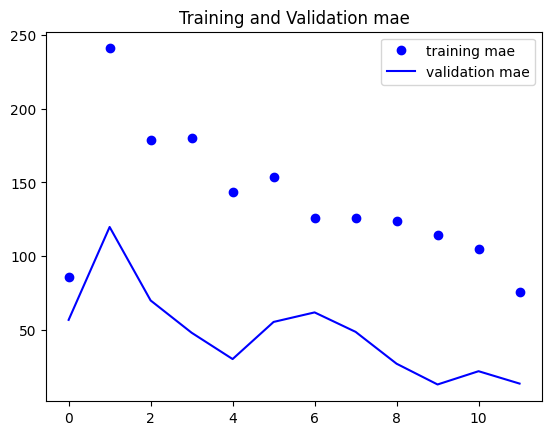

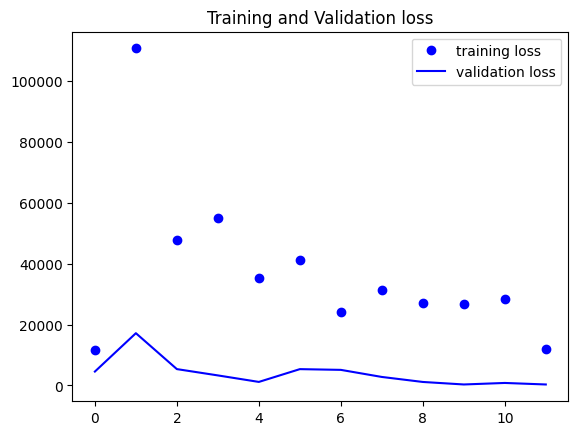

In [7]:
compare_TV(history)

In [8]:
# モデルの保存
model.save('coffee_taste_predictor_vgg16.h5')

# モデルの評価
loss, mae = model.evaluate(X_test, y_test)
print(f'MAE: {mae}')

c:\Users\morik\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step - loss: 129.2532 - mae: 8.3273
Mean Absolute Error on test data: 8.327322959899902


In [9]:
y_pred = model.predict(X_test)
y_pred

1/1 [==============================] - 2s 2s/step


array([[  2.4939072, -27.234638 ],
       [ -1.7592914,   0.9832551],
       [-12.611343 ,  -8.944832 ],
       [  4.1873794,  -7.6237717],
       [ -9.810536 , -12.411964 ],
       [  3.4174087,  -2.8430297],
       [  7.04214  ,   3.1889045],
       [ -0.3884227, -15.201796 ],
       [  2.0444977,  -7.682846 ]], dtype=float32)